In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import vectorbtpro as vbt

from datetime import date

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore", UserWarning)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 800
vbt.settings['plotting']['layout']['height'] = 400



In [2]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
df.fillna(method='pad')


/var/folders/8h/kn141vz15zx75vwjdp__w9fr0000gn/T/ipykernel_4214/1830426029.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
/var/folders/8h/kn141vz15zx75vwjdp__w9fr0000gn/T/ipykernel_4214/1830426029.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad')


,Open,High,Low,Close,Volume,signal
timestamp,,,,,,
2022-01-01 04:00:00,172.790,173.130,172.480,172.930,49675,1
2022-01-01 05:00:00,172.940,173.110,171.470,171.470,68973,1
2022-01-01 06:00:00,171.490,174.310,171.340,173.220,95595,1
2022-01-01 07:00:00,173.220,173.740,172.260,172.470,95494,1
2022-01-01 08:00:00,172.450,173.440,172.140,173.160,57926,1
...,...,...,...,...,...,...
2023-12-31 02:00:00,102.718,103.063,101.208,101.411,731765,1
2023-12-31 03:00:00,101.413,101.850,100.044,100.738,970135,2
2023-12-31 04:00:00,100.734,100.939,99.635,100.743,858035,1


In [3]:
data = vbt.Data.from_data(df)

In [4]:
open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

adx = vbt.ADX.run(high_price, low_price, close_price, window=14)
atr = vbt.ATR.run(high_price, low_price, close_price, window=14)
bbands = vbt.BBANDS.run(close_price, window=14)
rsi = vbt.RSI.run(close_price)
sma = vbt.MA.run(close_price, window=20)
strend = vbt.SUPERTREND.run(high_price, low_price, close_price, period=7, multiplier=3)

data.data['symbol']['ADX'] = adx.adx
data.data['symbol']['ATR'] = atr.atr
data.data['symbol']['BBAND'] = bbands.bandwidth
data.data['symbol']['RSI'] = rsi.rsi
data.data['symbol']['SMA'] = sma.ma
data.data['symbol']['STREND'] = strend.trend
data.data['symbol'] = data.data['symbol'].dropna()

In [5]:
predictor_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'ADX', 'ATR', 'BBAND', 'RSI', 'SMA', 'STREND']

X = data.data['symbol'][predictor_list]

y = data.data['symbol']['signal']

In [6]:
test_size = int(0.3*(len(X)))
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]



In [7]:
scl = StandardScaler()

X_train_scaled=scl.fit_transform(X_train)
X_train= X_train.assign(Open=X_train_scaled[:, 0])
X_train= X_train.assign(High=X_train_scaled[:, 1])
X_train= X_train.assign(Low=X_train_scaled[:, 2])
X_train= X_train.assign(Close=X_train_scaled[:, 3])
X_train= X_train.assign(Volume=X_train_scaled[:, 4])
X_train= X_train.assign(ADX=X_train_scaled[:, 5])
X_train= X_train.assign(ATR=X_train_scaled[:, 6])
X_train= X_train.assign(BBAND=X_train_scaled[:, 7])
X_train= X_train.assign(RSI=X_train_scaled[:, 8])
X_train= X_train.assign(SMA=X_train_scaled[:, 9])
X_train= X_train.assign(STREND=X_train_scaled[:, 10])


X_test_scaled=scl.transform(X_test)

X_test= X_test.assign(Open=X_test_scaled[:, 0])
X_test= X_test.assign(High=X_test_scaled[:, 1])
X_test= X_test.assign(Low=X_test_scaled[:, 2])
X_test= X_test.assign(Close=X_test_scaled[:, 3])
X_test= X_test.assign(Volume=X_test_scaled[:, 4])
X_test= X_test.assign(ADX=X_test_scaled[:, 5])
X_test= X_test.assign(ATR=X_test_scaled[:, 6])
X_test= X_test.assign(BBAND=X_test_scaled[:, 7])
X_test= X_test.assign(RSI=X_test_scaled[:, 8])
X_test= X_test.assign(SMA=X_test_scaled[:, 9])
X_test= X_test.assign(STREND=X_test_scaled[:, 10])

In [8]:
timestep = 80
X_train_list = []
y_train_list = []

# Adjust the range to stop at the last point where a full timestep can be created
for i in range(timestep, len(X_train) - timestep + 1):  # Adjust the loop to stop earlier
    X_train_list.append(np.array(X_train.iloc[i-timestep:i]))
    # Only append the next value instead of a range of values
    y_train_list.append(y_train.iloc[i])  # Assuming you want the next value as the target

X_test_list = []
y_test_list = []

for i in range(timestep, len(X_test) - timestep + 1):  # Adjust the loop to stop earlier
    X_test_list.append(np.array(X_test.iloc[i-timestep:i]))
    # Only append the next value instead of a range of values
    y_test_list.append(y_test.iloc[i])  # Assuming you want the next value as the target


In [9]:
x_train = np.array(X_train_list)
x_test = np.array(X_test_list)  

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

In [10]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your target labels tensor for the training data
# and it's already in the form of a 1D tensor of class indices (0 to C-1)

# Convert y_train to a numpy array if it's a tensor
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.cpu().numpy()
else:
    y_train_np = y_train  # Assuming y_train is already a numpy array

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [12]:
# Move class weights to the same device as your model and data
class_weights_tensor = class_weights_tensor.to('cpu')  # device could be 'cpu' or 'cuda'



In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

# Update these dimensions based on your dataset
input_dim = 11  # Number of features
hidden_dim = 32
num_layers = 2
output_dim = 3  # Number of classes

# Create the model
model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Use CrossEntropyLoss for multi-class classification
# Initialize the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)

# Assuming `optimizer` is your optimizer (e.g., Adam)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.8)


# Print the model's architecture
# print(model)


In [14]:
num_epochs = 100
# Assuming loss_fn is already defined as CrossEntropyLoss
# e.g., loss_fn = torch.nn.CrossEntropyLoss()
# For classification, it might be more informative to track accuracy or other metrics
# hist will track the loss for now
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_train_pred = model(x_train)

    # Compute loss
    loss = loss_fn(y_train_pred, y_train.long())  # Ensure y_train is of type torch.long
    if t % 20 == 0:  # Adjust logging frequency according to your preference
        print("Epoch ", t, "Loss: ", loss.item())
    hist[t] = loss.item()

    # Zero gradients before backward pass
    optimiser.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to all the learnable parameters
    loss.backward()

    # Update the parameters using the gradients and optimizer algorithm
    optimiser.step()
    
    # Step the scheduler
    scheduler.step()

    # Optional: Calculate and print accuracy or other metrics every few epochs
    # This is more meaningful for classification tasks
    if t % 20 == 0:  # Adjust as needed
        with torch.no_grad():  # No need to track gradients for validation
            y_pred_tags = torch.argmax(torch.softmax(y_train_pred, dim=1), dim=1)
            correct_preds = (y_pred_tags == y_train).float().sum()
            accuracy = correct_preds / y_train.shape[0]
            print(f'Epoch {t} Accuracy: {accuracy.item() * 100:.2f}%')


Epoch  0 Loss:  1.1010117530822754
Epoch 0 Accuracy: 3.25%
Epoch  20 Loss:  0.7235885262489319
Epoch 20 Accuracy: 31.65%
Epoch  40 Loss:  0.5675936341285706
Epoch 40 Accuracy: 46.89%
Epoch  60 Loss:  0.46440988779067993
Epoch 60 Accuracy: 52.81%
Epoch  80 Loss:  0.3468072712421417
Epoch 80 Accuracy: 67.81%


In [15]:
def plot_vals(hist):
    # Create a subplot with 2 rows and 1 column
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=list(range(len(hist))), y=hist, mode='lines+markers', name='loss over epochs'))

    fig.update_layout(
        template='plotly_dark',
        autosize=False,
        width=700,  # Set the width of the figure
        height=150,  # Set the height of the figure
        title='loss over epochs',  # You can set the title directly here
        title_font_size=10,
        margin=dict(l=5, r=5, b=5, t=30, pad=5),
        legend=dict(
            font=dict(
                size=5)
        )
    )
    fig.show()

In [16]:
plot_vals(hist)


In [17]:
with torch.no_grad():
    
    y_test_pred = model(x_test)
    # Convert logits to probabilities
    probabilities = torch.softmax(y_test_pred, dim=1)

    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, 1)
predicted_labels_numpy = predicted_labels.numpy()
len(predicted_labels_numpy)


5082

In [18]:
df_split = data.data['symbol'][-len(predicted_labels_numpy):].copy()
# len(df_split)
# df_split.shape
# predicted_labels_numpy.shape
df_split.loc[:, "signal"] = predicted_labels_numpy
signal = df_split['signal']
entries = signal == 2
exits = signal == 0

In [19]:
pf = vbt.Portfolio.from_signals(
    close=df_split.Close, 
    long_entries=entries, 
    long_exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)

In [24]:
print(pf.stats()["Total Return [%]"])
pf.plot({"orders", "cum_returns", }, settings=dict(bm_returns=False)).show()

38.083437051302305


Precision: 0.36
Recall: 0.48
F1 Score: 0.33
Confusion Matrix:
 [[  73   90    4]
 [ 871 2933  956]
 [   5   91   59]]


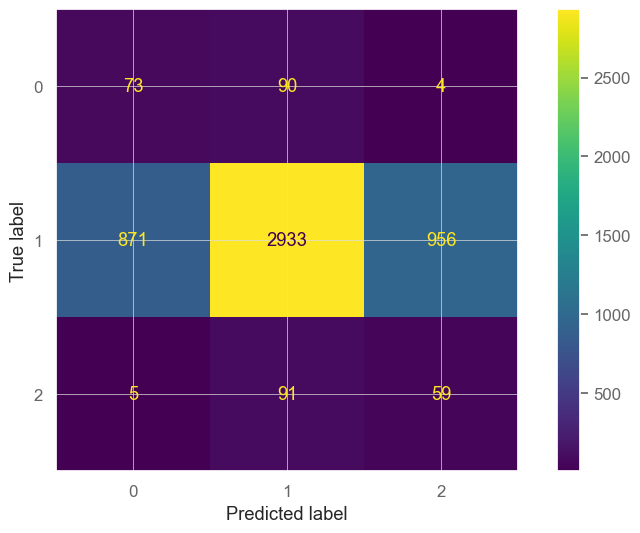

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Convert tensors to numpy arrays for use with Scikit-Learn
true_labels = y_test.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for unweighted mean
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:\n', conf_matrix)
ConfusionMatrixDisplay(conf_matrix).plot()